In this notebook, we will look at building a model that classifies whether a kickstarter project will become success or failure

Let's start with the imports

In [68]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample, shuffle

Let's initialize our random number for reproducible results

In [69]:
random = 2486

We use pandas to read and manipulate our data

In [70]:
df = pd.read_csv("data.csv")

In [71]:
df.shape

(108129, 14)

In [72]:
df.head(3)

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0


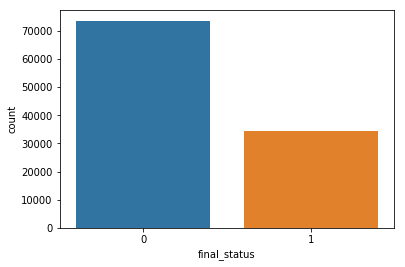

In [76]:
sns.countplot(df[target])

In [77]:
df[target].value_counts(normalize=True)

0    0.680373
1    0.319627
Name: final_status, dtype: float64

We see that the class levels are not balanced resulting in an imbalanced dataset. So, lets resample our data to have equal distribution of our class labels. There are many ways to balance the dataset like upsampling minor class, downsampling major class and smote. We'll proceed with upsampling the minor class (i.e.,) class1

In [78]:
df_0 = df.loc[df.final_status == 0, :].copy()

In [79]:
df_1 = df.loc[df.final_status == 1, :].copy()

In [80]:
df_0.shape, df_1.shape, df.shape

((73568, 14), (34561, 14), (108129, 14))

In [81]:
df_1 = resample(df_1, n_samples=df_0.shape[0], random_state=random)

In [82]:
df_1.shape

(73568, 14)

In [84]:
df = pd.concat([df_0, df_1], axis=0)

In [85]:
df.shape

(147136, 14)

In [87]:
df = shuffle(df, random_state=random)

In [86]:
df[target].value_counts(normalize=True)

1    0.5
0    0.5
Name: final_status, dtype: float64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147136 entries, 81853 to 104105
Data columns (total 14 columns):
project_id               147136 non-null object
name                     147133 non-null object
desc                     147127 non-null object
goal                     147136 non-null float64
keywords                 147136 non-null object
disable_communication    147136 non-null bool
country                  147136 non-null object
currency                 147136 non-null object
deadline                 147136 non-null int64
state_changed_at         147136 non-null int64
created_at               147136 non-null int64
launched_at              147136 non-null int64
backers_count            147136 non-null int64
final_status             147136 non-null int64
dtypes: bool(1), float64(1), int64(6), object(6)
memory usage: 15.9+ MB


We actually have all the time indicating columns as unix timestamps. Lets convert them.

In [89]:
df.created_at = pd.to_datetime(df.created_at, unit='s')
df.deadline = pd.to_datetime(df.deadline, unit='s')
df.launched_at = pd.to_datetime(df.launched_at, unit='s')
df.state_changed_at = pd.to_datetime(df.state_changed_at, unit='s')

And for some feature engineering

In [90]:
df['time_to_state_change'] = (df.state_changed_at - df.created_at).dt.days
df['deadline_and_launched_at'] = (df.deadline - df.launched_at).dt.days
df['deadline_and_state_changed_at'] = (df.deadline - df.state_changed_at).dt.days

In [92]:
df['name'] = df.name.fillna('').str.lower()
df['desc'] = df.desc.fillna('').str.lower()
df['keywords'] = df.keywords.str.lower()

In [93]:
df['state_mentioned_in_name'] = 0
df.loc[
    df.name.str.contains('\(canceled|suspended|failed|successful\)'),
    'state_mentioned_in_name'
] = 1

In [94]:
df.disable_communication = df.disable_communication.apply(lambda x: 1 if x else 0)

We have various currencies in our goal. Let's convert them all into US dollars

In [95]:
df.currency.unique()

array(['USD', 'GBP', 'AUD', 'CAD', 'EUR', 'SEK', 'NZD', 'DKK', 'NOK'],
      dtype=object)

In [96]:
currency_converter = {
    'USD': 1, #US DOLLAR
    'GBP': 1.38, #BRITISH POUND
    'CAD': 0.78, #CANADAIAN DOLLAR
    'AUD': 0.78, #AUSTRALIAN DOLLAR
    'NZD': 0.72, #NEW ZEALAND DOLLAR
    'EUR': 1.23, #EURO
    'SEK': 0.12, #SWEDISH KRONA
    'NOK': 0.13, #NORWEGIAN KRONE
    'DKK': 0.17, #DANISH KRONE
    'CHF': 1.07, #SWISS FRANC
    'HKD': 0.13, #HONG KONG DOLLAR
    'SGD': 0.76, #SINGAPORE DOLLAR
    'MXN': 0.053 #MEXICAN PESO
}

In [97]:
def convert_curr(curr, val):
    return currency_converter[curr] * val

In [98]:
df['converted_curr'] = df.apply(lambda x: convert_curr(x['currency'], x['goal']), axis=1)

Label encoding the country column...

In [99]:
df = pd.concat(
    [
        df,
        pd.get_dummies(df.country)
    ],
    axis=1
)

In [100]:
corr_cols = ['backers_count', 'time_to_state_change', 'deadline_and_launched_at',
             'deadline_and_state_changed_at', 'converted_curr']

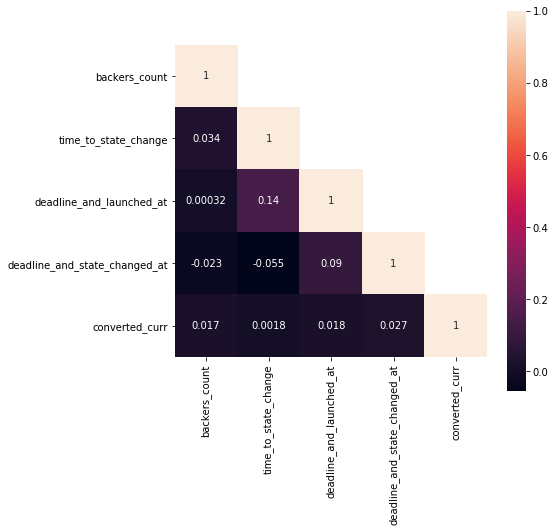

In [101]:
corr = df[corr_cols].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = mplt.subplots()
fig.set_size_inches(7, 7)
sns.heatmap(corr, mask=mask, square=True, annot=True)

/home/yesemsanthoshkumar/anaconda3/envs/kickstarter/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


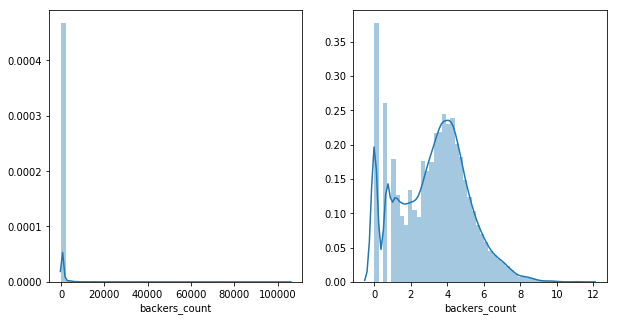

In [102]:
fig, ax = mplt.subplots(ncols=2)
fig.set_size_inches(10, 5)
sns.distplot(df.backers_count, ax=ax[0])
sns.distplot(np.log1p(df.backers_count), ax=ax[1])

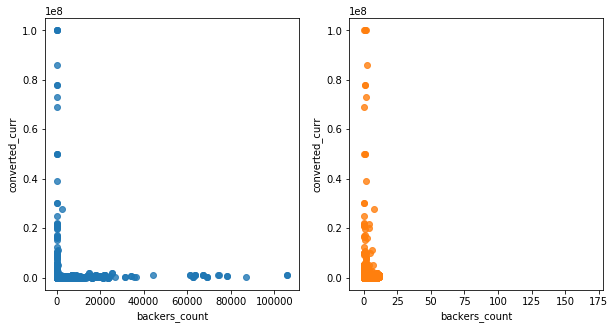

In [103]:
fig, ax = mplt.subplots(ncols=2)
fig.set_size_inches(10, 5)
sns.regplot(df.backers_count, df.converted_curr, ax=ax[0], fit_reg=False)
sns.regplot(np.log1p(df.backers_count), df.converted_curr, ax=ax[1], fit_reg=False)

In [107]:
features = list(df.columns)

In [108]:
columns_to_remove = ['project_id', 'name', 'desc', 'goal', 'keywords', 'country', 'currency', 'deadline',
                    'created_at', 'launched_at', 'state_changed_at', 'final_status']
for f in columns_to_remove:
    features.remove(f)
target = 'final_status'

In [109]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147136 entries, 81853 to 104105
Data columns (total 18 columns):
disable_communication            147136 non-null int64
backers_count                    147136 non-null int64
time_to_state_change             147136 non-null int64
deadline_and_launched_at         147136 non-null int64
deadline_and_state_changed_at    147136 non-null int64
state_mentioned_in_name          147136 non-null int64
converted_curr                   147136 non-null float64
AU                               147136 non-null uint8
CA                               147136 non-null uint8
DE                               147136 non-null uint8
DK                               147136 non-null uint8
GB                               147136 non-null uint8
IE                               147136 non-null uint8
NL                               147136 non-null uint8
NO                               147136 non-null uint8
NZ                               147136 non-null uint8
SE 

We'll start with a basic logistic regression model

In [110]:
lreg = LogisticRegression(random_state=random)

In [111]:
score1 = cross_val_score(lreg, df[features], df[target], cv=10)

In [112]:
print("Mean score: %s" % np.mean(score1))

Mean score: 0.8644247768380305


In [113]:
gbc = GradientBoostingClassifier(n_estimators=250, learning_rate=0.8, random_state=random)

In [114]:
score2 = cross_val_score(gbc, df[features], df[target], cv=10)

In [116]:
print("Mean score: %s" % np.mean(score2))

Mean score: 0.8893132827003584
